In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

path_dataset = "movielens100k.csv"
ratings = load_data(path_dataset)

number of items: 1682, number of users: 943


### Plot the number of ratings per movie and user

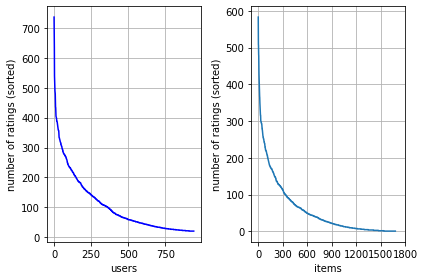

min # of items per user = 20, min # of users per item = 1.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [4]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1, seed=988):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(seed)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    # Get row index, col index and values of nonzero values in matrix
    nz_rows_cols_vals = sp.find(valid_ratings)
    print(nz_rows_cols_vals)
    # Generate random indices to shuffle values
    indices = np.random.permutation(valid_ratings.nnz)
    # Get max index
    max_test_id = int(p_test * valid_ratings.nnz)
    test_rows_cols_vals = [list_[indices[:max_test_id]] for list_ in nz_rows_cols_vals]
    train_rows_cols_vals = [list_[indices[max_test_id:]] for list_ in nz_rows_cols_vals]
    train_rows, train_cols, train_vals = train_rows_cols_vals
    test_rows, test_cols, test_vals = test_rows_cols_vals
    train = sp.csr_matrix((train_vals, (train_rows, train_cols)), shape = valid_ratings.shape)
    test = sp.csr_matrix((test_vals, (test_rows, test_cols)), shape = valid_ratings.shape)
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

(array([   1,    2,    3, ...,  987, 1065, 1091], dtype=int32), array([  0,   0,   0, ..., 942, 942, 942], dtype=int32), array([3., 4., 3., ..., 4., 3., 3.]))
Total number of nonzero elements in origial data:99999
Total number of nonzero elements in train data:88157
Total number of nonzero elements in test data:9795


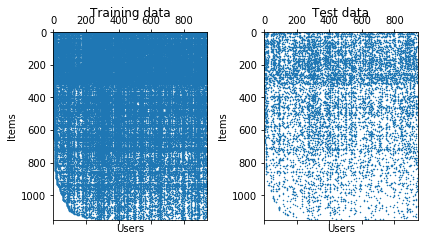

In [5]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)#, seed=355)
plot_train_test_data(train, test)

## Implementing Baselines 

### Use the global mean to do the prediction

In [6]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
      
    _, _, train_vals = sp.find(train)
    _, _, test_vals = sp.find(test)
    train_mean = np.mean(train_vals)
    error = (test_vals - train_mean)
    mse = error.dot(error)/len(test_vals)
    rmse = np.sqrt(mse)
    print("test RMSE of baseline using the global mean: {v}.".format(v=rmse))


baseline_global_mean(train, test)

test RMSE of baseline using the global mean: 1.1313319464258043.


### Use the user means as the prediction

In [7]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    nz_items, nz_users, nz_values = sp.find(train)
    _, _, nz_values_test = sp.find(test)
    users = set(nz_users) #Use only users with valid records
    for user in users:
        _, _, values = sp.find(train[:, user])
        _, _, test_values = sp.find(test[:, user])
        mean_values = np.mean(values)
        mse+=calculate_mse(real_label = test_values, prediction=mean_values)
    rmse = np.sqrt(mse / len(nz_values_test))
    print("test RMSE of the baseline using the user mean: {v}.".format(v=rmse))


baseline_user_mean(train, test)

test RMSE of the baseline using the user mean: 1.0530803439617218.


### Use the item means as the prediction

In [8]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    nz_items, nz_users, nz_values = sp.find(train)
    _, _, nz_values_test = sp.find(test)
    items = set(nz_items)
    for item in items:
        _, _, values = sp.find(train[item, :])
        _, _, test_values = sp.find(test[item, :])
        mean_values = np.mean(values)
        mse+=calculate_mse(real_label = test_values, prediction=mean_values)
    rmse = np.sqrt(mse / len(nz_values_test))
    print("test RMSE of the baseline using the item mean: {v}.".format(v=rmse))
        
baseline_item_mean(train, test)

test RMSE of the baseline using the item mean: 1.0220945778944375.


### Best results seem to be obained with the mean over users (item mean) which makes sense

### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [9]:
def init_MF(train, num_features):
    """Random init the parameter for matrix factorization.
    return:
         user_features: shape = num_features, num_user
         item_features: shape = num_features, num_item
    """
    num_item, num_user = train.shape
    user_features = np.random.random((num_features, num_user))
    item_features = np.random.random((num_features, num_item))
    return user_features, item_features

Compute the cost by the method of matrix factorization.


In [10]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    mse=0
    # W = item_features shape (k, d)
    # Z = user_features shape (k, n)
    for d, n in nz:
        x_dn = data[d, n]
        WZT_dn = item_features[:,d].dot(user_features[:,n].T)
        mse+=(x_dn - WZT_dn)**2
    mse/=len(nz)
    rmse=np.sqrt(mse)
    return rmse

In [15]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = 20     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)

    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    
    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        for d, n in nz_train:
            error = train[d, n] - item_features[:,d].dot(user_features[:,n].T)
            partial_W = error * user_features[:,n]
            partial_Z = error * item_features[:,d]
            item_features[:,d] = item_features[:,d] + gamma * (partial_W - lambda_item * item_features[:,d])
            user_features[:,n] = user_features[:,n] + gamma * (partial_Z - lambda_user * user_features[:,n])
        rmse = compute_error(train, user_features ,item_features, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        errors.append(rmse)

    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))
    return user_features, item_features
sgd_user_features, sgd_item_features = matrix_factorization_SGD(train, test)   

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.0384379987040262.
iter: 1, RMSE on training set: 1.0019403430739735.
iter: 2, RMSE on training set: 0.9839284637300889.
iter: 3, RMSE on training set: 0.9752674254651602.
iter: 4, RMSE on training set: 0.9721387631755072.
iter: 5, RMSE on training set: 0.9691218550129729.
iter: 6, RMSE on training set: 0.9656064599175618.
iter: 7, RMSE on training set: 0.9649424917068242.
iter: 8, RMSE on training set: 0.9624426759073016.
iter: 9, RMSE on training set: 0.9605231933394254.
iter: 10, RMSE on training set: 0.961067588202222.
iter: 11, RMSE on training set: 0.960165805377516.
iter: 12, RMSE on training set: 0.9599529830298836.
iter: 13, RMSE on training set: 0.9594665028352553.
iter: 14, RMSE on training set: 0.959314220637265.
iter: 15, RMSE on training set: 0.9586863730722781.
iter: 16, RMSE on training set: 0.9590118417263033.
iter: 17, RMSE on training set: 0.9586078049553561.
iter: 18, RMSE on training set: 0

### Learn the Matrix Factorization using Alternating Least Squares

In [73]:
def update_user_feature(train,
                        item_features,
                        lambda_user,
                        nnz_items_per_user,
                        nz_user_itemindices=0):
    """update user feature matrix."""
    """the best lambda is assumed to be nnz_items_per_user[user] * lambda_user"""
    nz_items, nz_users, nz_values = sp.find(train)
    users = set(nz_users)
    user_feature = np.zeros((item_features.shape[0], train.shape[1]))
    for user in users:
        items = train[:, user]
        rhs = item_features.dot(items.todense())
        reg_normal = item_features.dot(item_features.T) + nnz_items_per_user[
            user] * lambda_user * np.identity(item_features.shape[0])
        user_feature[:, user] = np.squeeze(np.linalg.solve(reg_normal, rhs))
    return user_feature


def update_item_feature(train,
                        user_features,
                        lambda_item,
                        nnz_users_per_item,
                        nz_item_userindices=0):
    """update item feature matrix."""
    """the best lambda is assumed to be nnz_items_per_item[item] * lambda_item"""
    nz_items, nz_users, nz_values = sp.find(train)
    items = set(nz_items)
    item_feature = np.zeros((user_features.shape[0], train.shape[0]))
    for item in items:
        users = train[item, :].T
        rhs = user_features.dot(users.todense())
        reg_normal = user_features.dot(user_features.T) + nnz_users_per_item[
            item] * lambda_item * np.identity(user_features.shape[0])
        item_feature[:, item] = np.squeeze(np.linalg.solve(reg_normal, rhs))
    return item_feature

In [74]:
from helpers import build_index_groups
#nz_train, nz_item_userindices, nz_user_itemindices = build_index_groups(train)


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20  # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]

    # set seed
    np.random.seed(988)
    # find the non-zero ratings indices
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    # init ALS
    user_features, item_features = init_MF(train, num_features)
    # get the number of non-zero ratings for each user and item
    nnz_items_per_user, nnz_users_per_item = train.getnnz(
        axis=0), train.getnnz(axis=1)

    # group the indices by row or column index
    nz_train, nz_item_userindices, nz_user_itemindices = build_index_groups(
        train)

    last_error = 0
    it = 0
    while change > stop_criterion:
        user_features = update_user_feature(train, item_features, lambda_user,
                                            nnz_items_per_user)
        item_features = update_item_feature(train, user_features, lambda_item,
                                            nnz_users_per_item)
        rmse = compute_error(train, user_features, item_features, nz_train)
        change = np.abs(rmse - last_error)
        last_error = rmse
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        it += 1
    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))
    return user_features, item_features


als_user_feature, als_item_features = ALS(train, test)

iter: 0, RMSE on training set: 3.4027654145921797.
iter: 1, RMSE on training set: 2.5749920406844184.
iter: 2, RMSE on training set: 2.4633117454939693.
iter: 3, RMSE on training set: 2.4310355965223693.
iter: 4, RMSE on training set: 2.4166028113086826.
iter: 5, RMSE on training set: 2.409120692750619.
iter: 6, RMSE on training set: 2.4049236164593615.
iter: 7, RMSE on training set: 2.402447234976515.
iter: 8, RMSE on training set: 2.4009492197765576.
iter: 9, RMSE on training set: 2.4000310489356416.
iter: 10, RMSE on training set: 2.399460647326921.
iter: 11, RMSE on training set: 2.3990998804957724.
iter: 12, RMSE on training set: 2.398866544109776.
iter: 13, RMSE on training set: 2.3987116609260433.
iter: 14, RMSE on training set: 2.398605843581537.
iter: 15, RMSE on training set: 2.3985312589081427.
RMSE on test data: 2.571848896355411.


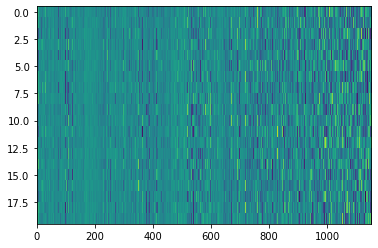

In [75]:
plt.imshow(sgd_item_features, aspect='auto')

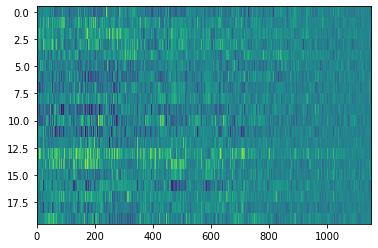

In [76]:
plt.imshow(als_item_features, aspect='auto')

# From solution

In [63]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    """the best lambda is assumed to be nnz_items_per_user[user] * lambda_user"""
    num_user = nnz_items_per_user.shape[0]
    num_feature = item_features.shape[0]
    lambda_I = lambda_user * sp.eye(num_feature)
    updated_user_features = np.zeros((num_feature, num_user))

    for user, items in nz_user_itemindices:
        # extract the columns corresponding to the prediction for given item
        M = item_features[:, items]
        
        # update column row of user features
        V = M @ train[items, user]
        A = M @ M.T + nnz_items_per_user[user] * lambda_I
        X = np.linalg.solve(A, V)
        updated_user_features[:, user] = np.copy(X.T)
    return updated_user_features

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    """the best lambda is assumed to be nnz_items_per_item[item] * lambda_item"""
    num_item = nnz_users_per_item.shape[0]
    num_feature = user_features.shape[0]
    lambda_I = lambda_item * sp.eye(num_feature)
    updated_item_features = np.zeros((num_feature, num_item))

    for item, users in nz_item_userindices:
        # extract the columns corresponding to the prediction for given user
        M = user_features[:, users]
        V = M @ train[item, users].T
        A = M @ M.T + nnz_users_per_item[item] * lambda_I
        X = np.linalg.solve(A, V)
        updated_item_features[:, item] = np.copy(X.T)
    return updated_item_features

In [64]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # get the number of non-zero ratings for each user and item
    nnz_items_per_user, nnz_users_per_item = train.getnnz(axis=0), train.getnnz(axis=1)
    
    # group the indices by row or column index
    nz_train, nz_item_userindices, nz_user_itemindices = build_index_groups(train)

    # run ALS
    print("\nstart the ALS algorithm...")
    while change > stop_criterion:
        # update user feature & item feature
        user_features = update_user_feature(
            train, item_features, lambda_user,
            nnz_items_per_user, nz_user_itemindices)
        item_features = update_item_feature(
            train, user_features, lambda_item,
            nnz_users_per_item, nz_item_userindices)

        error = compute_error(train, user_features, item_features, nz_train)
        print("RMSE on training set: {}.".format(error))
        error_list.append(error)
        change = np.fabs(error_list[-1] - error_list[-2])

    # evaluate the test error
    nnz_row, nnz_col = test.nonzero()
    nnz_test = list(zip(nnz_row, nnz_col))
    rmse = compute_error(test, user_features, item_features, nnz_test)
    print("test RMSE after running ALS: {v}.".format(v=rmse))

ALS(train, test)


start the ALS algorithm...
RMSE on training set: 1.2263373760926728.
RMSE on training set: 1.0673525571735258.
RMSE on training set: 1.0103740822602396.
RMSE on training set: 0.980222487172671.
RMSE on training set: 0.9623009337943613.
RMSE on training set: 0.9515109819612122.
RMSE on training set: 0.9449381472824395.
RMSE on training set: 0.9408026112991688.
RMSE on training set: 0.9381019654963927.
RMSE on training set: 0.9362817111045961.
RMSE on training set: 0.9350253653336978.
RMSE on training set: 0.9341434264078989.
RMSE on training set: 0.9335169349374969.
RMSE on training set: 0.9330681847259736.
RMSE on training set: 0.9327448295663889.
RMSE on training set: 0.9325107975581965.
RMSE on training set: 0.932340824581177.
RMSE on training set: 0.9322170126153019.
RMSE on training set: 0.9321265802143416.
test RMSE after running ALS: 0.9708451791195473.
